<a href="https://colab.research.google.com/github/mahdi943/imbalancedClassification/blob/master/Pollen_Family_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  Sample reading data from Directory and showing images names
Rhus = os.path.join('/content/drive/MyDrive/dataset/Amaranthaceae/Amaranthaceae sp')

train_daisy_names = os.listdir(Rhus)
print(train_daisy_names[:5])


['Amaranthaceae.jpg7.jpg', 'Amaranthaceae.jpg8.jpg', 'Amaranthaceae.jpg6.jpg', 'Amaranthaceae.jpg5.jpg', 'Amaranthaceae.jpg3.jpg']


Showing some Amaranthaceae sp pictures...



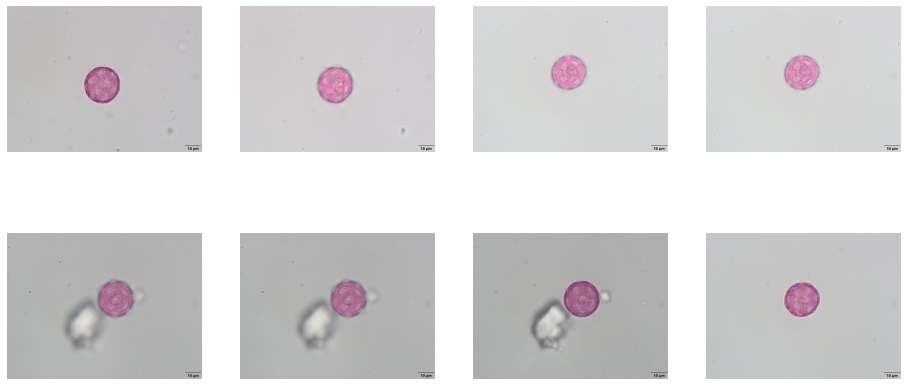

In [ ]:
# Show some image from dataset 

nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
Acanthus = [os.path.join(Rhus, fname) 
                for fname in train_daisy_names[pic_index-8:pic_index]]

print ("Showing some Amaranthaceae sp pictures...")
print()
for i, img_path in enumerate(Acanthus):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
## Extract all folder name existing in a data to take parent folder names as class names

datasetPath = '/content/drive/MyDrive/dataset/family'
x = os.scandir(datasetPath)
arr = []
for item in x:
    _, _, files = next(os.walk(item.path))
    file_count = len(files)
    arr.append(item.name)

len(arr)

46


## Initializing

In [ ]:
batch_size = 32
img_height, img_width = 300 , 300
num_class = len(arr)
epochs = 30

# Create Dataset

In [ ]:

# Divide data to train and validation
# Augmentation training data
# All images will be rescaled by 1./255
# I applied some augmentation on training data NOT on validation

datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   horizontal_flip=True,                                   
                                   rotation_range=45,
                                   validation_split=0.2
                                   )

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


validation_generator = val_datagen.flow_from_directory(
    datasetPath, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123) # set as validation data

test_generator = val_datagen.flow_from_directory(
    datasetPath, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123) # set as test data

train_generator = datagen.flow_from_directory(
        datasetPath,  # This is the source directory for training images
        target_size=(img_height, img_width),  # All images will be resized to img_height x img_width 
        batch_size = batch_size,
        # Specify the classes explicitly
        classes = arr,
        shuffle=False,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical',
        subset='training')



Found 336 images belonging to 46 classes.
Found 336 images belonging to 46 classes.
Found 1451 images belonging to 46 classes.


# Define class_weights 
for imbalanced data I tried to balance classes with this method

In [ ]:
# Since we have imbalanced data I used class weight to balance data during training 
# we can also oversample minority classes to balance data

from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(train_generator.classes),
                                                  y = train_generator.classes                                                    
                                    )
class_w = dict(zip(np.unique(train_generator.classes), class_weights))


# Model
## Resnet50

In [ ]:
from keras.applications import ResNet50
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width,3))


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import Input, Dense, Activation, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D


def pollen_model(base_model, img_shape = (img_height, img_width,3)):
        
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=img_shape) 
   
    # Forward pass to get the output of the last pooling layer
    X = base_model(inputs)

    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.5)(X) 
    
    #Flatten the output
    X = Flatten(name='flatten')(X)
    
    # Define the new binary classification head 
    X = Dense(1024, activation='relu')(X) 
    X = Dropout(0.5)(X)

    X = Dense(512, activation='relu')(X)  
    X = Dropout(0.5)(X)       
    
    X = Dense(num_class, activation='softmax')(X)  
          
    outputs = X
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Set the number of folds
num_folds = 5

# Define the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize an empty list to store the validation scores
val_scores = []

# Get the class indices
class_indices = train_generator.class_indices

# Get the number of samples per class
class_counts = train_generator.classes

# Get the number of samples
n_samples = len(class_counts)

# Get the indices of each sample
indices = np.arange(n_samples)

# Iterate over the folds
for train_index, val_index in kf.split(indices):
    # Split the data into train and validation sets
    train_indices, val_indices = indices[train_index], indices[val_index]

    train_gen = datagen.flow_from_directory(datasetPath,
                                             target_size=(img_height, img_width),
                                             class_mode='categorical',
                                             classes = class_indices,
                                             subset='training',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             )
    
    val_gen = val_datagen.flow_from_directory(datasetPath,
                                           target_size=(img_height, img_width),
                                           class_mode='categorical',
                                           classes=class_indices,
                                           subset='validation',
                                           batch_size=batch_size,
                                           )
    
    class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                      classes = np.unique(train_generator.classes),
                                                      y = train_generator.classes)
                                                                                         
    class_w = dict(zip(np.unique(train_generator.classes), class_weights))

    # Create a new model for each fold
    model = pollen_model (resnet, img_shape = (img_height, img_width,3))
    
    # Compile and fit the model on the train data
    model.compile(loss='categorical_crossentropy',
                    optimizer = optimizer, 
                    metrics=['accuracy'])
    
    history = model.fit(train_gen, epochs=epochs, 
                        validation_data=val_gen,
                        validation_steps = len(validation_generator),
                        steps_per_epoch = len(train_generator),
                        workers = 8,
                        batch_size = batch_size,
                        callbacks=[reduce_lr],
                        class_weight = class_w
                        )


    # Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate_generator(val_gen)
    val_scores.append(val_acc)
    
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label ='val loss')
    plt.legend()
    plt.show()
    print("\n")
    plt.figure(figsize=(7,4))
    plt.plot([i+1 for i in range(epochs)], history.history['accuracy'],'-o',c='k',lw=2,markersize=9)
    plt.grid(True)
    plt.title("Training accuracy with epochs\n",fontsize=18)
    plt.xlabel("Training epochs",fontsize=15)
    plt.ylabel("Training accuracy",fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
    model.save('/content/drive/MyDrive/models')
# Compute the mean and standard deviation of the validation scores
mean_val_acc = np.mean(val_scores)
std_val_acc = np.std(val_scores)
print(f'Validation accuracy: {mean_val_acc:.4f} +/- {std_val_acc:.4f}')


In [ ]:
# score = model.evaluate(test_generator, verbose=0)
val_loss, val_acc = model.evaluate(test_generator)
print('Test loss:', val_loss)
print('Test accuracy:', val_acc)

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Set the number of folds
num_folds = 5

# Define the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize an empty list to store the validation scores
val_scores = []

# Get the class indices
class_indices = train_generator.class_indices

# Get the number of samples per class
class_counts = train_generator.classes

# Get the number of samples
n_samples = len(class_counts)

# Get the indices of each sample
indices = np.arange(n_samples)

# Iterate over the folds
for train_index, val_index in kf.split(indices):



    # Split the data into train and validation sets
    train_indices, val_indices = indices[train_index], indices[val_index]

    train_gen = datagen.flow_from_directory(datasetPath,
                                             target_size=(img_height, img_width),
                                             class_mode='categorical',
                                             classes = class_indices,
                                             subset='training',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             seed=1)
    
    val_gen = val_datagen.flow_from_directory(datasetPath,
                                           target_size=(img_height, img_width),
                                           class_mode='categorical',
                                           classes=class_indices,
                                           subset='validation',
                                           batch_size=batch_size,
                                           shuffle=False)
    
    class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                      classes = np.unique(train_generator.classes),
                                                      y = train_generator.classes)
                                                                                         
    class_w = dict(zip(np.unique(train_generator.classes), class_weights))

    # Create a new model for each fold
    model = pollen_model (resnet, img_shape = (img_height, img_width,3))
    
    # Compile and fit the model on the train data
    model.compile(loss='categorical_crossentropy',
                    optimizer = optimizer, 
                    metrics=['accuracy'])
    
    history = model.fit(train_gen, epochs=epochs, 
                        validation_data=val_gen,
                        validation_steps = len(validation_generator),
                        steps_per_epoch = len(train_generator),
                        workers = 4,
                        batch_size = batch_size,
                        callbacks=[reduce_lr],
                        class_weight = class_w
                        )


    # Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate_generator(val_gen)
    val_scores.append(val_acc)

# Compute the mean and standard deviation of the validation scores
mean_val_acc = np.mean(val_scores)
std_val_acc = np.std(val_scores)
print(f'Validation accuracy: {mean_val_acc:.4f} +/- {std_val_acc:.4f}')


Found 1451 images belonging to 46 classes.
Found 160 images belonging to 46 classes.
Epoch 1/25
46/46 [==============================] - 404s 8s/step - loss: 4.1242 - accuracy: 0.0131 - val_loss: 11.1402 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/25
46/46 [==============================] - 109s 2s/step - loss: 3.7069 - accuracy: 0.0407 - val_loss: 3.6868 - val_accuracy: 0.0188 - lr: 0.0100
Epoch 3/25
46/46 [==============================] - 100s 2s/step - loss: 3.4651 - accuracy: 0.0731 - val_loss: 3.9743 - val_accuracy: 0.0125 - lr: 0.0100
Epoch 4/25
46/46 [==============================] - 107s 2s/step - loss: 3.2734 - accuracy: 0.0861 - val_loss: 4.9978 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 5/25
46/46 [==============================] - 111s 2s/step - loss: 3.1159 - accuracy: 0.0965 - val_loss: 25.4344 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 6/25
46/46 [==============================] - 107s 2s/step - loss: 2.8550 - accuracy: 0.1371 - val_loss: 14.9064 - val_accuracy: 0.00

<ipython-input-14-eb196cb4a674>:79: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_acc = model.evaluate_generator(val_gen)


Found 1451 images belonging to 46 classes.
Found 160 images belonging to 46 classes.
Epoch 1/25
46/46 [==============================] - 115s 2s/step - loss: 3.6057 - accuracy: 0.0565 - val_loss: 3.7701 - val_accuracy: 0.0250 - lr: 0.0010
Epoch 2/25
46/46 [==============================] - 109s 2s/step - loss: 2.5094 - accuracy: 0.1599 - val_loss: 3.8221 - val_accuracy: 0.0188 - lr: 0.0010
Epoch 3/25
46/46 [==============================] - 107s 2s/step - loss: 1.8132 - accuracy: 0.2881 - val_loss: 3.5407 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 4/25
46/46 [==============================] - 107s 2s/step - loss: 1.6546 - accuracy: 0.3019 - val_loss: 3.8185 - val_accuracy: 0.0437 - lr: 0.0010
Epoch 5/25
46/46 [==============================] - 111s 2s/step - loss: 1.3665 - accuracy: 0.3618 - val_loss: 3.7208 - val_accuracy: 0.0812 - lr: 0.0010
Epoch 6/25
46/46 [==============================] - 108s 2s/step - loss: 1.0950 - accuracy: 0.4066 - val_loss: 3.8168 - val_accuracy: 0.0875 - lr

Unfortunately, Google Colab stopped working on the fifth fold during the training phase, so I just repeated for two folds and saved the model. At the end of the fourth fold, the model had 81% training accuracy and 23% validation accuracy. Because I just utilized 25 epochs, I believe it will improve with more epochs.

Found 1451 images belonging to 46 classes.
Found 160 images belonging to 46 classes.
Epoch 1/25
46/46 [==============================] - 120s 2s/step - loss: 3.7297 - accuracy: 0.0558 - val_loss: 5.3097 - val_accuracy: 0.0312 - lr: 0.0100
Epoch 2/25
46/46 [==============================] - 105s 2s/step - loss: 3.3691 - accuracy: 0.0868 - val_loss: 10.4582 - val_accuracy: 0.0312 - lr: 0.0100
Epoch 3/25
46/46 [==============================] - 100s 2s/step - loss: 3.1468 - accuracy: 0.0992 - val_loss: 5.9598 - val_accuracy: 0.0312 - lr: 0.0100
Epoch 4/25
46/46 [==============================] - 105s 2s/step - loss: 3.1360 - accuracy: 0.1254 - val_loss: 6.8195 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 5/25
46/46 [==============================] - 120s 2s/step - loss: 2.9410 - accuracy: 0.0944 - val_loss: 9.2095 - val_accuracy: 0.0063 - lr: 0.0100
Epoch 6/25
46/46 [==============================] - 108s 2s/step - loss: 2.7383 - accuracy: 0.1337 - val_loss: 13.5798 - val_accuracy: 0.0063 - 

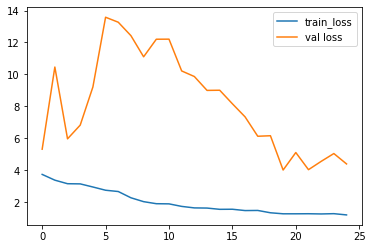

Found 1451 images belonging to 46 classes.
Found 160 images belonging to 46 classes.
Epoch 1/25
46/46 [==============================] - 117s 2s/step - loss: 3.7730 - accuracy: 0.0448 - val_loss: 3.7573 - val_accuracy: 0.0688 - lr: 0.0010
Epoch 2/25
46/46 [==============================] - 99s 2s/step - loss: 3.0740 - accuracy: 0.1158 - val_loss: 3.7570 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 3/25
46/46 [==============================] - 106s 2s/step - loss: 2.4922 - accuracy: 0.1640 - val_loss: 3.9957 - val_accuracy: 0.0375 - lr: 0.0010
Epoch 4/25
46/46 [==============================] - 115s 2s/step - loss: 2.1007 - accuracy: 0.2033 - val_loss: 3.7214 - val_accuracy: 0.0312 - lr: 0.0010
Epoch 5/25
46/46 [==============================] - 108s 2s/step - loss: 1.7627 - accuracy: 0.2274 - val_loss: 4.8842 - val_accuracy: 0.0375 - lr: 0.0010
Epoch 6/25
46/46 [==============================] - 107s 2s/step - loss: 1.6321 - accuracy: 0.2695 - val_loss: 4.7310 - val_accuracy: 0.0312 - lr:

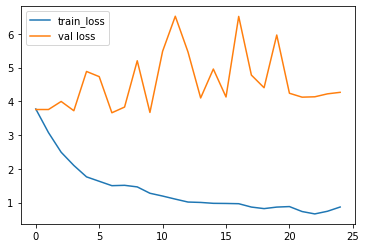

Validation accuracy: 0.0844 +/- 0.0156


In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Set the number of folds
num_folds = 5

# Define the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Initialize an empty list to store the validation scores
val_scores = []

# Get the class indices
class_indices = train_generator.class_indices

# Get the number of samples per class
class_counts = train_generator.classes

# Get the number of samples
n_samples = len(class_counts)

# Get the indices of each sample
indices = np.arange(n_samples)

# Iterate over the folds
for train_index, val_index in kf.split(indices):



    # Split the data into train and validation sets
    train_indices, val_indices = indices[train_index], indices[val_index]

    train_gen = datagen.flow_from_directory(datasetPath,
                                             target_size=(img_height, img_width),
                                             class_mode='categorical',
                                             classes = class_indices,
                                             subset='training',
                                             batch_size=batch_size,
                                             shuffle=True,
                                             )
    
    val_gen = val_datagen.flow_from_directory(datasetPath,
                                           target_size=(img_height, img_width),
                                           class_mode='categorical',
                                           classes=class_indices,
                                           subset='validation',
                                           batch_size=batch_size,
                                           )
    
    class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                      classes = np.unique(train_generator.classes),
                                                      y = train_generator.classes)
                                                                                         
    class_w = dict(zip(np.unique(train_generator.classes), class_weights))

    # Create a new model for each fold
    model = pollen_model (resnet, img_shape = (img_height, img_width,3))
    
    # Compile and fit the model on the train data
    model.compile(loss='categorical_crossentropy',
                    optimizer = optimizer, 
                    metrics=['accuracy'])
    
    history = model.fit(train_gen, epochs=epochs, 
                        validation_data=val_gen,
                        validation_steps = len(validation_generator),
                        steps_per_epoch = len(train_generator),
                        workers = 4,
                        batch_size = batch_size,
                        callbacks=[reduce_lr],
                        class_weight = class_w
                        )


    # Evaluate the model on the validation data
    val_loss, val_acc = model.evaluate(val_gen)
    val_scores.append(val_acc)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label ='val loss')
    plt.legend()
    plt.show()

# Compute the mean and standard deviation of the validation scores
mean_val_acc = np.mean(val_scores)
std_val_acc = np.std(val_scores)
print(f'Validation accuracy: {mean_val_acc:.4f} +/- {std_val_acc:.4f}')


In [ ]:
model.save('/content/drive/MyDrive/')

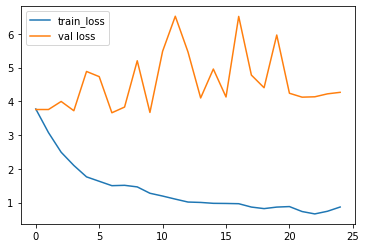

In [ ]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()

In [ ]:
# score = model.evaluate(test_generator, verbose=0)
val_loss, val_acc = model.evaluate(test_generator)
print('Test loss:', val_loss)
print('Test accuracy:', val_acc)

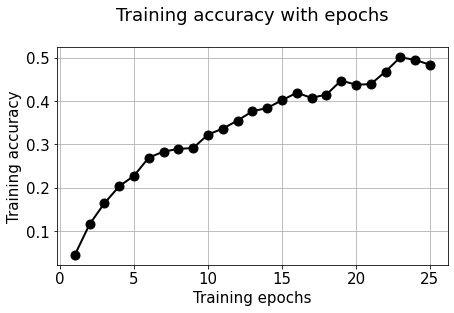

In [ ]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(epochs)],history.history['accuracy'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

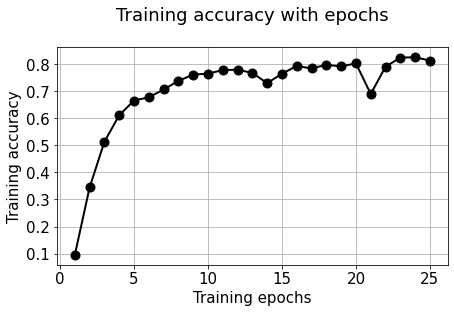

In [ ]:
# I plot 4th fold manually, because google colab stopped on 5th fold and didn't let me run on GPU more that a limited number of runs. 

fold4acc = [0.0951, 0.3446, 0.5134,0.6113,0.6657,0.67750,0.7064,0.7381,0.7615,0.7650,0.7781,0.7795,0.7677,0.7298,0.7650,0.7932,0.7843,0.7974,0.7919,0.8029,0.6899,0.7905,0.8243,0.8256,0.8132]

plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(epochs)],fold4acc,'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

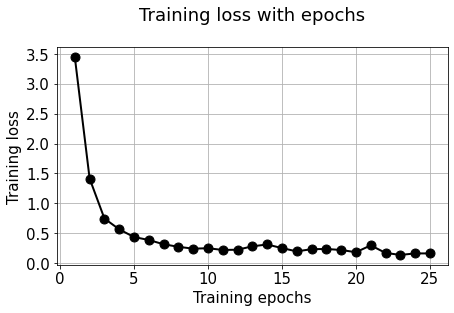

In [ ]:
# I plot 4th fold manually, because google colab stopped on 5th fold and didn't let me run on GPU more that a limited number of runs. 


fold4loss = [3.4434,1.4127,0.7447,0.5639,0.4348,0.3856,0.3141,0.2715,0.2404,0.2477,0.2187,0.2229,0.2798,0.3103,0.2500,0.1950,0.2320,0.2351,0.2184,0.1809,0.2958,0.1693,0.1358,0.1607,0.1611]

plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(25)], fold4loss,'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

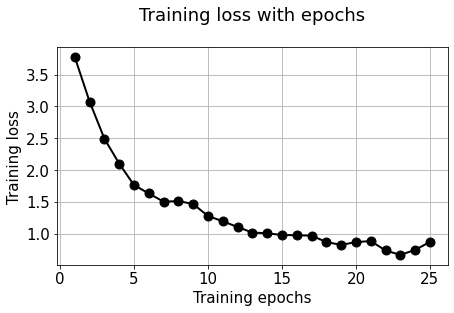

In [ ]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(epochs)],history.history['loss'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()